In [ ]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_absolute_error
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
from pathlib import Path
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/NN_MEFs/

CAISO_Data_2019_2021_NN_Ts.csv	FF_models  MLP_MEFs.ipynb


## Parameters

In [ ]:
work_dir = "drive/MyDrive/NN_MEFs"
data_file = f"{work_dir}/CAISO_Data_2019_2021_NN_Ts.csv"
model_save_dir = f"{work_dir}/FF_models"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_out = 3    # 3 output parameters: MEF, MDF, interecept. 
             # inclusion of intercept is debatable (we'd love to have a model where it is zero),
             # and so far it has not much impacted r^2.
             # once we do test train split i only want to keep it if it notably improves model accuracy

## data exploration

In [ ]:
data_df = pd.read_csv(data_file)

In [ ]:
data_df.head()

,Unnamed: 0,Load,Net Load,Total_CO2_Emissions,Total_SO2_Emissions,Total_NOX_Emissions,VRE,delta_Load,delta_Net_Load,delta_Total_CO2_Emissions,...,Hour,Month,Day,Pas_Temp,SJ_Temp,NH_Temp,SB_Temp,Sac_Temp,Fres_Temp,LB_Temp
0,2019-01-01 00:00:00,22822.964472,20502.358502,5.103942e+06,425.327933,1632.821698,2320.593616,-1285.054865,-1255.110267,-337029.794143,...,0,1,1,49.2,33.6,50.7,46.3,33.9,54.9,54.9
1,2019-01-01 01:00:00,21879.620618,19606.836908,4.867578e+06,404.315852,1557.650531,2272.780097,-944.689268,-896.922625,-243021.833700,...,1,1,1,42.7,30.7,49.8,45.6,34.1,54.0,54.0
2,2019-01-01 02:00:00,21257.454020,19056.267637,4.723101e+06,383.695714,1496.197481,2201.182455,-614.641020,-545.206677,-144846.797503,...,2,1,1,40.4,30.1,50.3,45.1,32.7,52.8,52.8
3,2019-01-01 03:00:00,20974.800758,18871.418601,4.693112e+06,380.561848,1466.329836,2103.388502,-281.391674,-191.565227,-24776.569759,...,3,1,1,39.2,29.1,47.2,44.4,32.1,52.6,52.6
4,2019-01-01 04:00:00,20327.083333,18012.666667,5.032423e+06,711.911968,2391.657870,2314.666667,30.416667,74.416667,49254.136541,...,4,1,1,37.6,28.4,42.5,44.3,31.4,52.0,52.0


## Data Loading and pre-processing

In [ ]:
# read in the processed data. there should be zero nans or missing data.
CAISO_Data = pd.read_csv(data_file, index_col=0)
CAISO_Data.index = pd.to_datetime(CAISO_Data.index)

### Feature engineering...

## Temporal features
CAISO_Data.loc[:,"Day_of_Year"] = [instant.timetuple().tm_yday for instant in CAISO_Data.index]
# CAISO_Data.loc[:,"Is_Weekend"] = [instant.weekday() > 4 for instant in CAISO_Data.index]
# for day_of_week in range(7):
#     CAISO_Data.loc[:,f"Day_of_Week={day_of_week}"] = [instant.weekday() ==day_of_week for instant in CAISO_Data.index]

## Recent history features
# prev_time_steps = [1,2,24]#,3]
# for i in prev_time_steps:
#     # CAISO_Data.loc[:,f"Load_t-{i}"] = ([np.nan] * i) + list(CAISO_Data.iloc[:-i].loc[:,"Load"])
#     # CAISO_Data.loc[:,f"VRE_t-{i}"] = ([np.nan] * i) + list(CAISO_Data.iloc[:-i].loc[:,"VRE"])
#     CAISO_Data.loc[:,f"d_emissions_t-{i}"] = ([np.nan] * i) + list(CAISO_Data.iloc[:-i].loc[:,"delta_Total_CO2_Emissions"])
# # Drop rows that don't have all prev-time-step features
# CAISO_Data = CAISO_Data.iloc[max(prev_time_steps):]


## load and VRE derivatives
# CAISO_Data.loc[:,"Load_d1"] = [np.nan] + list(CAISO_Data.iloc[1:].loc[:,"Load"].values - CAISO_Data.iloc[:-1].loc[:,"Load"].values)
# CAISO_Data.loc[:,"Load_d2"] = [np.nan, np.nan] + list(CAISO_Data.iloc[2:].loc[:,"Load_d1"].values - CAISO_Data.iloc[1:-1].loc[:,"Load_d1"].values)
# CAISO_Data.loc[:,"VRE_d1"] = [np.nan] + list(CAISO_Data.iloc[1:].loc[:,"VRE"].values - CAISO_Data.iloc[:-1].loc[:,"VRE"].values)
# CAISO_Data.loc[:,"VRE_d2"] = [np.nan, np.nan] + list(CAISO_Data.iloc[2:].loc[:,"VRE_d1"].values - CAISO_Data.iloc[1:-1].loc[:,"VRE_d1"].values)
# # Drop rows that don't have all features
# CAISO_Data = CAISO_Data.iloc[2:]


num_samples = len(CAISO_Data)

# create masks for train, validation and test data
percent_train, percent_val, percent_test = .6, .2, .2
num_train, num_val = int(percent_train * num_samples), int(percent_val * num_samples)
num_test = num_samples - num_train - num_val
set_assignments = np.array([1 for i in range(num_train)] + [2 for i in range(num_val)] + [3 for i in range(num_test)])
np.random.seed(1)
np.random.shuffle(set_assignments)
train_mask = set_assignments == 1
val_mask = set_assignments == 2
test_mask = set_assignments == 3
CAISO_train = CAISO_Data.loc[train_mask]
CAISO_val = CAISO_Data.loc[val_mask]
CAISO_test = CAISO_Data.loc[test_mask]

## old features we've tried
# feature_cols = ['Load', 'VRE', 'Hour', 'Month', 'Day', 'Pas_Temp', 'SJ_Temp', 'NH_Temp', 'SB_Temp', 'Sac_Temp', 'Fres_Temp', 'LB_Temp']
# feature_cols = ['Load', 'VRE', 'Hour', 'Day_of_Year', 'Is_Weekend', 'Pas_Temp', 'SJ_Temp', 'NH_Temp', 'SB_Temp', 'Sac_Temp', 'Fres_Temp', 'LB_Temp']
# feature_cols = ['Load', 'VRE', 'Hour', 'Day_of_Year', 'Pas_Temp', 'SJ_Temp', 'NH_Temp', 'SB_Temp', 'Sac_Temp', 'Fres_Temp', 'LB_Temp']
# feature_cols.extend([f"Day_of_Week={day_of_week}" for day_of_week in range(7)])

feature_cols = ['Load', 'VRE', 'Hour', 'Day_of_Year']
# feature_cols.extend([f"Load_t-{i}" for i in prev_time_steps] + [f"VRE_t-{i}" for i in prev_time_steps])
# feature_cols.extend(["Load_d1", "Load_d2", "VRE_d1", "VRE_d2"])
# feature_cols.extend(["delta_Load", "delta_VRE"])
# feature_cols.extend([f"d_emissions_t-{i}" for i in prev_time_steps])

# specify x and y data #TODO seems like there may be some unnecessary operations here... 
train_x = torch.tensor(CAISO_train[feature_cols].values.astype(np.float32))
val_x = torch.tensor(CAISO_val[feature_cols].values.astype(np.float32))
test_x = torch.tensor(CAISO_test[feature_cols].values.astype(np.float32))
# train_y = torch.tensor(np.array(CAISO_train['delta_Total_CO2_Emissions'].values).astype(np.float32))
# val_y = torch.tensor(np.array(CAISO_val['delta_Total_CO2_Emissions'].values).astype(np.float32))
# test_y = torch.tensor(np.array(CAISO_test['delta_Total_CO2_Emissions'].values).astype(np.float32))


# standardize data based on mean and variance of train data
scaler = preprocessing.StandardScaler()
scaler.fit(train_x)
train_x = torch.tensor(scaler.transform(train_x)).to(device)
val_x = torch.tensor(scaler.transform(val_x)).to(device)
test_x = torch.tensor(scaler.transform(test_x)).to(device)

In [ ]:
CAISO_Data.head()

,Load,Net Load,Total_CO2_Emissions,Total_SO2_Emissions,Total_NOX_Emissions,VRE,delta_Load,delta_Net_Load,delta_Total_CO2_Emissions,delta_Total_SO2_Emissions,...,SJ_Temp,NH_Temp,SB_Temp,Sac_Temp,Fres_Temp,LB_Temp,Day_of_Year,d_emissions_t-1,d_emissions_t-2,d_emissions_t-24
2019-01-02 00:00:00,21302.833333,21101.416667,5.943198e+06,706.598543,2809.132307,201.416667,-996.500000,-949.583333,-514537.672003,-28.866116,...,31.6,44.3,33.7,31.8,46.3,46.3,2,-347759.394205,-431972.059251,-337029.794143
2019-01-02 01:00:00,20601.750000,20386.750000,5.390742e+06,614.071061,2441.373928,214.833333,-701.083333,-714.666667,-552455.804690,-92.527482,...,30.1,39.1,35.2,30.8,43.1,43.1,2,-514537.672003,-347759.394205,-243021.833700
2019-01-02 02:00:00,20271.416667,20002.833333,5.601578e+06,532.972949,2352.518468,268.666667,-330.333333,-383.916667,210835.582471,-81.098112,...,29.6,36.9,35.4,29.8,41.2,41.2,2,-552455.804690,-514537.672003,-144846.797503
2019-01-02 03:00:00,20383.416667,20090.916667,5.677326e+06,563.077187,2584.969715,292.333333,112.000000,88.083333,75748.112826,30.104238,...,28.2,35.9,35.2,29.5,40.1,40.1,2,210835.582471,-552455.804690,-24776.569759
2019-01-02 04:00:00,21148.166667,20833.000000,6.015296e+06,719.733904,2973.857829,315.166667,764.750000,742.083333,337969.564672,156.656716,...,28.3,37.3,34.1,29.6,38.9,38.9,2,75748.112826,210835.582471,49254.136541


In [ ]:
train_x.shape

torch.Size([15768, 7])

## define model and set params

In [ ]:
def get_model(n_input, hidden_dims, n_out, dropout_p):
    
    layers = [nn.Linear(n_input, hidden_dims[0]),
              nn.BatchNorm1d(hidden_dims[0]),
              nn.ReLU(),
              nn.Dropout(dropout_p)
             ]
    for layer in range(len(hidden_dims)-1):
        cur_hidden, next_hidden = hidden_dims[layer], hidden_dims[layer+1]
        layers.extend([nn.Linear(cur_hidden, next_hidden),
                       nn.BatchNorm1d(next_hidden),
                       nn.ReLU(),
                       nn.Dropout(dropout_p)
                      ])
    layers.append(nn.Linear(hidden_dims[-1], n_out))
    
    model = nn.Sequential(*layers)
    return model

# Stepp: gotta start with tensors and use torch math functions to keep as tensors
# def mse_loss(pred_coeff, CAISO_Data):
#     delta_load_tensor = torch.tensor(np.array(CAISO_Data['delta_Load'].values).astype(np.float32))
#     delta_vre_tensor = torch.tensor(np.array(CAISO_Data['delta_VRE'].values).astype(np.float32))
#     MEF_preds = pred_coeff[:,0]
#     MDF_preds = pred_coeff[:,1]
#     pred_y_demand = torch.mul(delta_load_tensor, MEF_preds)
#     pred_y_vre = torch.mul(delta_vre_tensor, MDF_preds)
#     pred_y = torch.add(pred_y_vre, pred_y_demand)
#     act_y = torch.tensor(np.array(CAISO_Data['delta_Total_CO2_Emissions'].values).astype(np.float32))
#     loss = nn.MSELoss()(pred_y, act_y)
#     return loss

def mse_loss_regularized_preds_l2(pred_coeff, CAISO_Data, MEF_reg_weight, MDF_reg_weight, bias_term):
    delta_load_tensor = torch.tensor(np.array(CAISO_Data['delta_Load'].values).astype(np.float32))
    delta_vre_tensor = torch.tensor(np.array(CAISO_Data['delta_VRE'].values).astype(np.float32))
    MEF_preds = pred_coeff[:,0]
    MDF_preds = pred_coeff[:,1]
    pred_y_demand = torch.mul(delta_load_tensor, MEF_preds)
    pred_y_vre = torch.mul(delta_vre_tensor, MDF_preds)
    pred_y = pred_y_vre + pred_y_demand
    if bias_term:
        bias_preds = pred_coeff[:,2]
        pred_y += bias_preds
    act_y = torch.tensor(np.array(CAISO_Data['delta_Total_CO2_Emissions'].values).astype(np.float32))

    # Compute MEF regularization term (sum(MEF^2 + intercept if MEF < 0 for MEF in examples))
    invalid_MEFs = nn.functional.relu(-MEF_preds)  # keep negative MEFs and zero others
    count_invalid_MEFs = torch.count_nonzero(invalid_MEFs)
    MEF_reg_intercept = 4420  # based on an average value of -65 seen amongst invalids when trained without regularization
    MEF_reg = torch.dot(invalid_MEFs, invalid_MEFs) + (count_invalid_MEFs * MEF_reg_intercept)

    # Compute MDF regularization term (sum(MDF^2 + intercept if MDF > 0 for MDF in examples))
    invalid_MDFs = nn.functional.relu(MDF_preds)  # keep negative MEFs and zero others
    count_invalid_MDFs = torch.count_nonzero(invalid_MDFs)
    MDF_reg_intercept = 538  # based on an average value of +23 seen amongst invalids when trained without regularization
    MDF_reg = torch.dot(invalid_MDFs, invalid_MDFs) + (count_invalid_MDFs * MDF_reg_intercept)

    loss = nn.MSELoss()(pred_y, act_y) + (MEF_reg_weight * MEF_reg) + (MDF_reg_weight * MDF_reg)
    return loss

def mse_loss_regularized_preds_l1(pred_coeff, CAISO_Data, MEF_reg_weight, MDF_reg_weight, bias_term):
    delta_load_tensor = torch.tensor(np.array(CAISO_Data['delta_Load'].values).astype(np.float32))
    delta_vre_tensor = torch.tensor(np.array(CAISO_Data['delta_VRE'].values).astype(np.float32))
    MEF_preds = pred_coeff[:,0]
    MDF_preds = pred_coeff[:,1]
    pred_y_demand = torch.mul(delta_load_tensor, MEF_preds)
    pred_y_vre = torch.mul(delta_vre_tensor, MDF_preds)
    pred_y = pred_y_vre + pred_y_demand
    if bias_term:
        bias_preds = pred_coeff[:,2]
        pred_y += bias_preds
    act_y = torch.tensor(np.array(CAISO_Data['delta_Total_CO2_Emissions'].values).astype(np.float32))

    # Compute MEF regularization term (sum(MEF + intercept if MEF < 0 for MEF in examples))
    invalid_MEFs = nn.functional.relu(-MEF_preds)  # keep negative MEFs and zero others
    count_invalid_MEFs = torch.count_nonzero(invalid_MEFs)
    MEF_reg_intercept = 66.5  # The average value seen amongst invalids when trained without regularization
    MEF_reg = torch.sum(invalid_MEFs) + (count_invalid_MEFs * MEF_reg_intercept)

    # Compute MDF regularization term (sum(MDF + intercept if MDF > 0 for MDF in examples))
    invalid_MDFs = nn.functional.relu(MDF_preds)  # keep negative MEFs and zero others
    count_invalid_MDFs = torch.count_nonzero(invalid_MDFs)
    MDF_reg_intercept = 23.2  # The average value seen amongst invalids when trained without regularization
    MDF_reg = torch.sum(invalid_MDFs) + (count_invalid_MDFs * MDF_reg_intercept)

    loss = nn.MSELoss()(pred_y, act_y) + (MEF_reg_weight * MEF_reg) + (MDF_reg_weight * MDF_reg)
    return loss

## Model Training

Helpers for printing results

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
def print_results(train_losses, train_pred_coeff, train_CAISO_Data, val_losses, val_pred_coeff, val_CAISO_Data, bias_term, plt_save_dir=None):
    #plot loss vs epochs
    fig, axs = plt.subplots(1,2)
    axs[0].plot(train_losses[1000:])
    axs[0].set_title("Train Set")
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')

    axs[1].plot(val_losses[1000:])
    axs[1].set_title("Val Set")
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    
    plt.tight_layout()
    plt.show()
    
    if plt_save_dir:
        fig.savefig(f"{plt_save_dir}/train_val_losses.png") 

    # count number of invalid values predicted
    invalid_train_MEFs, invalid_train_MDFs = get_count_invalid_preds(train_pred_coeff)
    invalid_val_MEFs, invalid_val_MDFs = get_count_invalid_preds(val_pred_coeff)

    #add MEF, MDF and interecept results to orignial frame #TODO once again seems like more operations than necessary
    coeff_df=pd.DataFrame(data=train_pred_coeff.detach().numpy(), columns=['MEF', 'MDF', 'Intercept'])
    train_CAISO_Data.loc[:,'MEF']=coeff_df.loc[:,'MEF'].values
    train_CAISO_Data.loc[:,'MDF']=coeff_df.loc[:,'MDF'].values
    if bias_term:
        train_CAISO_Data.loc[:,'Intercept']=coeff_df.loc[:,'Intercept'].values

    #calculate some error stuff. rn i am thinking R2 is the best measure of error
    d_emissions = train_CAISO_Data.loc[:,'MEF'] * train_CAISO_Data.loc[:,'delta_Load'] \
                + train_CAISO_Data.loc[:,'MDF'] * train_CAISO_Data.loc[:,'delta_VRE']
    if bias_term:
        d_emissions += train_CAISO_Data.loc[:,'Intercept'] 
    train_CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions'] = d_emissions
    train_CAISO_Data.loc[:,'Error']=train_CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions']-train_CAISO_Data.loc[:,'delta_Total_CO2_Emissions']
    train_CAISO_Data.loc[:,'%_Error']=np.abs(train_CAISO_Data.loc[:,'Error'])/np.abs(train_CAISO_Data.loc[:,'delta_Total_CO2_Emissions'])
    print("Train Set:")
    print(f"\tMean Emissions Change = {np.mean(np.abs(train_CAISO_Data['delta_Total_CO2_Emissions'])):.2f}")
    print(f"\tMean Error = {np.mean(np.abs(train_CAISO_Data['Error'])):.2f}")
    print(f"\tInvalid MEFs,MDFs = {invalid_train_MEFs},{invalid_train_MDFs}")
    print(f"\tR Squared = {r2_score(train_CAISO_Data['delta_Total_CO2_Emissions'],train_CAISO_Data['Predicted_delta_Total_CO2_Emissions']):.4f}")
    
    #TODO make this better so we don't have copy pasta
    #add MEF, MDF and interecept results to orignial frame #TODO once again seems like more operations than necessary
    coeff_df=pd.DataFrame(data=val_pred_coeff.detach().numpy(), columns=['MEF', 'MDF', 'Intercept'])
    val_CAISO_Data.loc[:,'MEF']=coeff_df.loc[:,'MEF'].values
    val_CAISO_Data.loc[:,'MDF']=coeff_df.loc[:,'MDF'].values
    if bias_term:
        val_CAISO_Data.loc[:,'Intercept']=coeff_df.loc[:,'Intercept'].values

    #calculate some error stuff. rn i am thinking R2 is the best measure of error
    d_emissions = val_CAISO_Data.loc[:,'MEF'] * val_CAISO_Data.loc[:,'delta_Load'] \
                + val_CAISO_Data.loc[:,'MDF']*val_CAISO_Data.loc[:,'delta_VRE']
    if bias_term:
        d_emissions += val_CAISO_Data.loc[:,'Intercept'] 
    val_CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions'] = d_emissions
    val_CAISO_Data.loc[:,'Error']=val_CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions']-val_CAISO_Data.loc[:,'delta_Total_CO2_Emissions']
    val_CAISO_Data.loc[:,'%_Error']=np.abs(val_CAISO_Data.loc[:,'Error'])/np.abs(val_CAISO_Data.loc[:,'delta_Total_CO2_Emissions'])
    print("Val Set:")
    print(f"\tMean Emissions Change = {np.mean(np.abs(val_CAISO_Data['delta_Total_CO2_Emissions'])):.2f}")
    print(f"\tMean Error = {np.mean(np.abs(val_CAISO_Data['Error'])):.2f}")
    print(f"\tInvalid MEFs,MDFs = {invalid_val_MEFs},{invalid_val_MDFs}")
    print(f"\tR Squared = {r2_score(val_CAISO_Data['delta_Total_CO2_Emissions'],val_CAISO_Data['Predicted_delta_Total_CO2_Emissions']):.4f}")
    
def get_r_squared(pred_coeff, CAISO_Data, bias_term):
    coeff_df=pd.DataFrame(data=pred_coeff.detach().numpy(), columns=['MEF', 'MDF', 'Intercept'])
    pred_delta_total_co2_emissions = coeff_df['MEF'].values * CAISO_Data['delta_Load'] \
                                   + coeff_df['MDF'].values * CAISO_Data['delta_VRE']
    if bias_term:
        pred_delta_total_co2_emissions += coeff_df['Intercept'].values
    r2 = r2_score(CAISO_Data['delta_Total_CO2_Emissions'], pred_delta_total_co2_emissions)
    return r2

def get_mean_abs_err(pred_coeff, CAISO_Data, bias_term):
    coeff_df=pd.DataFrame(data=pred_coeff.detach().numpy(), columns=['MEF', 'MDF', 'Intercept'])
    pred_delta_total_co2_emissions = coeff_df['MEF'].values * CAISO_Data['delta_Load'] \
                                   + coeff_df['MDF'].values * CAISO_Data['delta_VRE']
    if bias_term:
        pred_delta_total_co2_emissions += coeff_df['Intercept'].values
    mean_abs_err = mean_absolute_error(CAISO_Data['delta_Total_CO2_Emissions'], pred_delta_total_co2_emissions)
    return mean_abs_err

def get_count_invalid_preds(pred_coeff):
    # preds=pred_coeff.detach().numpy()
    count_neg_MEFs = torch.sum(pred_coeff[:,0] <= 0).item() #sum(preds[:,0] <= 0) # MEF must be greater than 0
    count_pos_MDFs = torch.sum(pred_coeff[:,1] > 0).item() #sum(preds[:,1] > 0)  # MDF must be less than or equal to 0
    return count_neg_MEFs, count_pos_MDFs

Train the model

In [ ]:
def train_model_with_params(train_x, val_x, CAISO_train, CAISO_val, n_out, hidden_dims, learning_rate, weight_decay, dropout_p, \
                            loss_function, MEF_reg_weight, MDF_reg_weight, bias_term, model_dir_prefix=None, epochs=10000):
    
    print(f"Model Params: hidden_dims={','.join(str(dim) for dim in hidden_dims)}, learning_rate={learning_rate}, weight_decay={weight_decay}, dropout={dropout_p}" \
          + f", loss_function={loss_function}, MEF_reg_weight={MEF_reg_weight}, MDF_reg_weight={MDF_reg_weight}, bias={bias_term}")
    n_input = train_x.shape[1]
    print(f"num input features: {n_input}")
    model = get_model(n_input, hidden_dims, n_out, dropout_p)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model_dir = model_save_dir
    if model_dir_prefix:
        model_dir += f"/{model_dir_prefix}"
    model_dir += f"/hidden={','.join(str(dim) for dim in hidden_dims)}," \
              + f"LR={learning_rate},w_decay={weight_decay},dropout={dropout_p},MEF_reg={MEF_reg_weight},MDF_reg={MDF_reg_weight},bias={bias_term}"
    
    Path(model_dir).mkdir(parents=True, exist_ok=True)

    with open(f"{model_dir}/experiment_settings.txt", 'w+') as f:
        f.write("Model Params:")
        f.write(f"\thidden_dims={','.join(str(dim) for dim in hidden_dims)}")
        f.write(f"\tlearning_rate={learning_rate}")
        f.write(f"\tweight_decay={weight_decay}")
        f.write(f"\tdropout={dropout_p}")
        f.write(f"\tloss_function={loss_function}")
        f.write(f"\tMEF_reg_weight={MEF_reg_weight}")
        f.write(f"\tMDF_reg_weight={MDF_reg_weight}")
        f.write(f"\tbias={bias_term}")
        f.write("Features:")
        f.write("\t" + ", ".join(feature_cols))

    model.to(device)

    min_save_r2 = .87 # Don't save model unless gets above .87 as we know we can do this well.
    best_r2 = -np.inf 
    best_epoch = None
    save_model_path = None
    last_save_epoch = None
    last_save_r2 = -np.inf
    
    train_losses = []
    val_losses = []
    for epoch in tqdm(range(epochs)):
        # tell model we are training (for bathnorm layer, dropout...)
        model.train()
        train_pred_coeff=model(train_x.float()).cpu()
        train_loss=loss_function(train_pred_coeff, CAISO_train, MEF_reg_weight, MDF_reg_weight, bias_term)
        train_losses.append(train_loss.item())
        
        # tell model we are evaluating
        model.eval()
        val_pred_coeff=model(val_x.float()).cpu()
        val_loss=loss_function(val_pred_coeff, CAISO_val, MEF_reg_weight, MDF_reg_weight, bias_term)
        val_losses.append(val_loss.item())
        val_r2 = get_r_squared(val_pred_coeff, CAISO_val, bias_term)

        # always keep best r2 updated
        if val_r2 > best_r2:
            best_r2 = val_r2
            best_epoch = epoch
        # check if we should save... we need good enough r2 and no invalids
        if val_r2 > max(last_save_r2, min_save_r2):
            if sum(get_count_invalid_preds(val_pred_coeff))==0:
                # also check training invalids... Let's recompute with eval mode
                model.eval()
                eval_mode_train_preds=model(train_x.float()).cpu()
                if sum(get_count_invalid_preds(eval_mode_train_preds))==0:
                    if save_model_path:
                        Path(save_model_path).unlink() # delete prev-best model
                    model_save_name = f"epoch={epoch},r2={val_r2:.4f},Invalids=0.pth"
                    save_model_path = f"{model_dir}/{model_save_name}"
                    torch.save(model.state_dict(), save_model_path)
                    last_save_epoch = epoch
                    last_save_r2 = val_r2

        
        if epoch % 1000 == 0:
            invalid_train_MEFs, invalid_train_MDFs = get_count_invalid_preds(train_pred_coeff)
            invalid_val_MEFs, invalid_val_MDFs = get_count_invalid_preds(val_pred_coeff)
            train_r2 = get_r_squared(train_pred_coeff, CAISO_train, bias_term)
            # val_r2 = get_r_squared(val_pred_coeff, CAISO_val, bias_term)
            print(f"[Epoch {epoch}]")
            print(f"\tTrain Set: Loss={train_loss.item():.3e}, R Squared={train_r2:.4f}, Invalid MEFs={invalid_train_MEFs}, Invalid MDFs={invalid_train_MDFs}")
            print(f"\tVal Set: Loss={val_loss.item():.3e}, R Squared={val_r2:.4f}, Invalid MEFs={invalid_val_MEFs}, Invalid MDFs={invalid_val_MDFs}")
        model.zero_grad()
        train_loss.backward()
        optimizer.step()
        # stop if we aren't improving after 10k epochs
        if best_epoch and epoch > 10000 + best_epoch:
            print("Early stopping as we haven't made an improvement on validation set in 10,000 epochs.")
            break

    print_results(train_losses, train_pred_coeff, CAISO_train, val_losses, val_pred_coeff, CAISO_val, bias_term, model_dir)
    print(f"best R Squared seen on epoch {best_epoch}: {best_r2:.4f}")
    if save_model_path:
        print(f"best R Squared with no invalids predicted in train/val seen on epoch {last_save_epoch}: {last_save_r2:.4f}")
    else:
        print(f"No model was saved because no model that had no train/val invalids reached {min_save_r2} validation R2.")
        
    return save_model_path

### Train with big model, regularization, and bias term

Model Params: hidden_dims=512,256, learning_rate=0.001, weight_decay=0.01, dropout=0.5, loss_function=<function mse_loss_regularized_preds_l2 at 0x7fb95ac569e0>, MEF_reg_weight=10000.0, MDF_reg_weight=10000.0, bias=True


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=7.937e+11, R Squared=-0.0008, Invalid MEFs=10015, Invalid MDFs=8711
	Val Set: Loss=5.601e+11, R Squared=-0.0006, Invalid MEFs=5216, Invalid MDFs=3451
[Epoch 1000]
	Train Set: Loss=4.792e+10, R Squared=0.8423, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.633e+10, R Squared=0.8509, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=4.270e+10, R Squared=0.8595, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.083e+10, R Squared=0.8686, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=4.168e+10, R Squared=0.8628, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.988e+10, R Squared=0.8717, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=4.100e+10, R Squared=0.8651, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.942e+10, R Squared=0.8732, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=4.043e+10, R Squared=0.8670, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.905e+10, R Squared=0.8743, Invalid MEFs=0, Invalid MDFs=

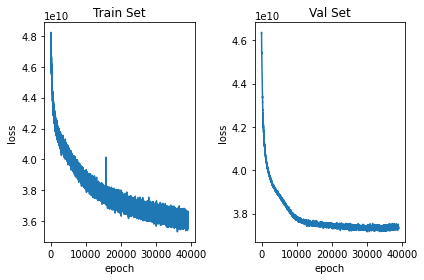

Train Set:
	Mean Emissions Change = 411703.26
	Mean Error = 137286.72
	Invalid MEFs,MDFs = 4,1
	R Squared = 0.8823
Val Set:
	Mean Emissions Change = 417399.67
	Mean Error = 140281.42
	Invalid MEFs,MDFs = 0,0
	R Squared = 0.8798
best R Squared seen on epoch 31070: 0.8804
best R Squared with no invalids predicted in train/val seen on epoch 31070: 0.8804


In [ ]:
hidden_dim_settings = [[512,256]]
lrs = [.001]
weight_decays = [.01]
dropout_probs = [0.5]
bias_term = True

# regularization_weights = [[1e6,1e6]]#,[1e8,1e8],[1e10,1e10]]
# loss_function = mse_loss_regularized_preds_l1
# save_prefix = "l1_output_reg_and_bias"

# for hidden_dims in hidden_dim_settings:
#     for lr in lrs:
#         for weight_decay in weight_decays:
#             for dropout_p in dropout_probs:
#               for reg_weights in regularization_weights:
#                   train_model_with_params(hidden_dims, lr, weight_decay, dropout_p, CAISO_Data,
#                                           loss_function, *reg_weights, bias_term, save_prefix, epochs=40000)


regularization_weights = [[1e4,1e4]]#,[1e6,1e6],[1e8,1e8],[1e10,1e10]]
loss_function = mse_loss_regularized_preds_l2
save_prefix = "l2_output_reg_and_bias"

for hidden_dims in hidden_dim_settings:
    for lr in lrs:
        for weight_decay in weight_decays:
            for dropout_p in dropout_probs:
              for reg_weights in regularization_weights:
                  train_model_with_params(hidden_dims, lr, weight_decay, dropout_p, CAISO_Data,
                                          loss_function, *reg_weights, bias_term, save_prefix, epochs=40000)

### trying with prev time step features

Model Params: hidden_dims=512,256, learning_rate=0.001, weight_decay=0.01, dropout=0.5, loss_function=<function mse_loss_regularized_preds_l1 at 0x7f29cdfc87a0>, MEF_reg_weight=1000000.0, MDF_reg_weight=1000000.0, bias=True


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=6.679e+11, R Squared=0.0017, Invalid MEFs=3960, Invalid MDFs=4148
	Val Set: Loss=3.473e+11, R Squared=0.0004, Invalid MEFs=42, Invalid MDFs=1706
[Epoch 1000]
	Train Set: Loss=4.877e+10, R Squared=0.8407, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.577e+10, R Squared=0.8499, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=4.082e+10, R Squared=0.8667, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.890e+10, R Squared=0.8724, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=3.867e+10, R Squared=0.8738, Invalid MEFs=0, Invalid MDFs=1
	Val Set: Loss=3.831e+10, R Squared=0.8744, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=3.776e+10, R Squared=0.8769, Invalid MEFs=1, Invalid MDFs=0
	Val Set: Loss=3.860e+10, R Squared=0.8735, Invalid MEFs=0, Invalid MDFs=1
[Epoch 5000]
	Train Set: Loss=3.696e+10, R Squared=0.8793, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.846e+10, R Squared=0.8739, Invalid MEFs=0, Invalid MDFs=0
[Ep

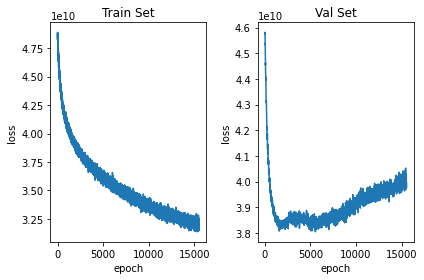

Train Set:
	Mean Emissions Change = 413969.58
	Mean Error = 132160.58
	Invalid MEFs,MDFs = 0,0
	R Squared = 0.8951
Val Set:
	Mean Emissions Change = 412305.84
	Mean Error = 142900.41
	Invalid MEFs,MDFs = 0,0
	R Squared = 0.8690
best R Squared seen on epoch 6540: 0.8752
best R Squared with no invalids predicted in train/val seen on epoch 6540: 0.8752


In [ ]:
hidden_dim_settings = [[512,256]]
lrs = [.001]
weight_decays = [.01]
dropout_probs = [0.5]
bias_term = True

regularization_weights = [[1e6,1e6]]
loss_function = mse_loss_regularized_preds_l1
save_prefix = "prev_3_timestep_features_l1_output_reg_and_bias"

for hidden_dims in hidden_dim_settings:
    for lr in lrs:
        for weight_decay in weight_decays:
            for dropout_p in dropout_probs:
              for reg_weights in regularization_weights:
                  train_model_with_params(hidden_dims, lr, weight_decay, dropout_p, CAISO_Data,
                                          loss_function, *reg_weights, bias_term, save_prefix, epochs=40000)

### trying with d_load and d_vre features

In [ ]:
hidden_dims = [512,256]
lr = .001
weight_decay = .01
dropout_p = 0.5
bias_term = True

reg_weights = [1e6,1e6]
loss_function = mse_loss_regularized_preds_l1
save_prefix = "delta1_load_and_vre_l1_output_reg_and_bias"

best_model_path = train_model_with_params(train_x, val_x, CAISO_train, CAISO_val, n_out, hidden_dims, lr, weight_decay, dropout_p,
                                          loss_function, *reg_weights, bias_term, save_prefix, epochs=40000)

Model Params: hidden_dims=512,256, learning_rate=0.001, weight_decay=0.01, dropout=0.5, loss_function=<function mse_loss_regularized_preds_l1 at 0x7f29cc09fd40>, MEF_reg_weight=1000000.0, MDF_reg_weight=1000000.0, bias=True
num input features: 6


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=1.275e+12, R Squared=-0.0018, Invalid MEFs=10779, Invalid MDFs=10481
	Val Set: Loss=7.509e+11, R Squared=-0.0008, Invalid MEFs=5033, Invalid MDFs=4497


KeyboardInterrupt: ignored

### trying with d_emissions_t-n features

Model Params: hidden_dims=512,256, learning_rate=0.001, weight_decay=0.01, dropout=0.5, loss_function=<function mse_loss_regularized_preds_l1 at 0x7f6b20b97e60>, MEF_reg_weight=1000000.0, MDF_reg_weight=1000000.0, bias=True
num input features: 7


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=1.276e+12, R Squared=-0.0008, Invalid MEFs=11088, Invalid MDFs=9593
	Val Set: Loss=6.957e+11, R Squared=-0.0010, Invalid MEFs=4524, Invalid MDFs=3686
[Epoch 1000]
	Train Set: Loss=4.833e+10, R Squared=0.8420, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.841e+10, R Squared=0.8430, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=3.840e+10, R Squared=0.8744, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.898e+10, R Squared=0.8736, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=3.722e+10, R Squared=0.8783, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.806e+10, R Squared=0.8766, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=3.614e+10, R Squared=0.8818, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.764e+10, R Squared=0.8780, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=3.621e+10, R Squared=0.8821, Invalid MEFs=2, Invalid MDFs=0
	Val Set: Loss=3.755e+10, R Squared=0.8783, Invalid MEFs=0, Invalid MDFs=

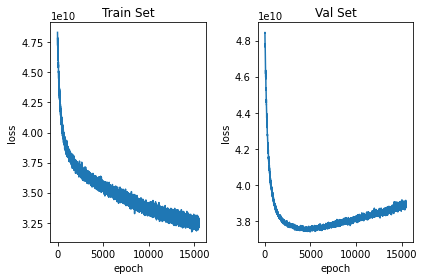

Train Set:
	Mean Emissions Change = 414235.65
	Mean Error = 133180.81
	Invalid MEFs,MDFs = 2,0
	R Squared = 0.8935
Val Set:
	Mean Emissions Change = 416013.57
	Mean Error = 141121.63
	Invalid MEFs,MDFs = 0,0
	R Squared = 0.8740
best R Squared seen on epoch 6507: 0.8788
best R Squared with no invalids predicted in train/val seen on epoch 4275: 0.8784


In [ ]:
hidden_dims = [512,256]
lr = .001
weight_decay = .01
dropout_p = 0.5
bias_term = True

reg_weights = [1e6,1e6]
loss_function = mse_loss_regularized_preds_l1
save_prefix = "d_emissions1_2_24_feature"

best_model_path = train_model_with_params(train_x, val_x, CAISO_train, CAISO_val, n_out, hidden_dims, lr, weight_decay, dropout_p,
                                          loss_function, *reg_weights, bias_term, save_prefix, epochs=40000)

## Inference on all data

In [ ]:
## below we can load specific models instead of best one found in most recent experiment

## best model with no invalids on train/val and no bias
# best_model_dir = "drive/MyDrive/NN_MEFs/FF_models/l2_output_reg/hidden=512,256,LR=0.001,w_decay=0.01,dropout=0.5,MEF_reg=10000.0,MDF_reg=10000.0"
# model_file = "epoch=38122,r2=0.8806,Invalids=0.pth"
# best_model_path = f"{best_model_dir}/{model_file}"

# # best model with no invalids on train/val with bias
# best_model_dir = "drive/MyDrive/NN_MEFs/FF_models/l1_output_reg_and_bias/hidden=512,256,LR=0.001,w_decay=0.01,dropout=0.5,MEF_reg=1000000.0,MDF_reg=1000000.0,bias=True"
# model_file = "epoch=36772,r2=0.8805,Invalids=0.pth"
# best_model_path = f"{best_model_dir}/{model_file}"



In [ ]:
hidden_dims = [512,256]
bias_term = True
dropout_p = 0.5
n_input = train_x.shape[1]


model = get_model(n_input, hidden_dims, n_out, dropout_p)
model.to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()

train_pred_coeff = model(train_x.float()).cpu()
val_pred_coeff = model(val_x.float()).cpu()
test_pred_coeff = model(test_x.float()).cpu()

print("R Squared:")
print(f"\tTrain: {get_r_squared(train_pred_coeff, CAISO_train, bias_term):.4f}")
print(f"\tVal: {get_r_squared(val_pred_coeff, CAISO_val, bias_term):.4f}")
print(f"\tTest: {get_r_squared(test_pred_coeff, CAISO_test, bias_term):.4f}")
print("Mean Absolute Error:")
print(f"\tTrain: {get_mean_abs_err(train_pred_coeff, CAISO_train, bias_term):.2f}")
print(f"\tVal: {get_mean_abs_err(val_pred_coeff, CAISO_val, bias_term):.2f}")
print(f"\tTest: {get_mean_abs_err(test_pred_coeff, CAISO_test, bias_term):.2f}")
print("Count Invalid Values Predicted:")
invalid_train_MEFs, invalid_train_MDFs = get_count_invalid_preds(train_pred_coeff)
invalid_val_MEFs, invalid_val_MDFs = get_count_invalid_preds(val_pred_coeff)
invalid_test_MEFs, invalid_test_MDFs = get_count_invalid_preds(test_pred_coeff)
print(f"\tTrain: Invalid MEFs={invalid_train_MEFs}, Invalid MDFs={invalid_train_MDFs}")
print(f"\tVal: Invalid MEFs={invalid_val_MEFs}, Invalid MDFs={invalid_val_MDFs}")
print(f"\tTest: Invalid MEFs={invalid_test_MEFs}, Invalid MDFs={invalid_test_MDFs}")


R Squared:
	Train: 0.8921
	Val: 0.8805
	Test: 0.8755
Mean Absolute Error:
	Train: 131028.76
	Val: 140016.71
	Test: 139890.26
Count Invalid Values Predicted:
	Train: Invalid MEFs=0, Invalid MDFs=0
	Val: Invalid MEFs=0, Invalid MDFs=0
	Test: Invalid MEFs=0, Invalid MDFs=0


### Put the MEFs and MDFs from all sets back together and in order into the original DF for viewing

In [ ]:
all_preds_w_timestamps = list(zip(CAISO_val.index, val_pred_coeff.detach().numpy())) \
                        + list(zip(CAISO_train.index, train_pred_coeff.detach().numpy())) \
                        + list(zip(CAISO_test.index, test_pred_coeff.detach().numpy()))
all_preds_w_timestamps.sort(key=lambda pair: pair[0])
all_preds_ordered = np.array([pair[1] for pair in all_preds_w_timestamps])

In [ ]:
all_MEFs_ordered = all_preds_ordered[:,0]
all_MDFs_ordered = all_preds_ordered[:,1]
all_intercepts_ordered = all_preds_ordered[:,2]

In [ ]:
CAISO_Data.loc[:,"MEF"] = all_MEFs_ordered
CAISO_Data.loc[:,"MDF"] = all_MDFs_ordered
if bias_term:
    CAISO_Data.loc[:,"Intercept"] = all_intercepts_ordered

#calculate some error stuff. rn i am thinking R2 is the best measure of error
d_emissions = CAISO_Data.loc[:,'MEF'] * CAISO_Data.loc[:,'delta_Load'] \
            + CAISO_Data.loc[:,'MDF'] * CAISO_Data.loc[:,'delta_VRE']
if bias_term:
    d_emissions += CAISO_Data.loc[:,"Intercept"]
CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions'] = d_emissions
CAISO_Data.loc[:,'Error']=CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions']-CAISO_Data.loc[:,'delta_Total_CO2_Emissions']
CAISO_Data.loc[:,'%_Error']=np.abs(CAISO_Data.loc[:,'Error'])/np.abs(CAISO_Data.loc[:,'delta_Total_CO2_Emissions'])
print("Whole Data Set:")
print(f"\tMean Emissions Change = {np.mean(np.abs(CAISO_Data['delta_Total_CO2_Emissions'])):.2f}")
print(f"\tR Squared = {r2_score(CAISO_Data['delta_Total_CO2_Emissions'], CAISO_Data['Predicted_delta_Total_CO2_Emissions']):.4f}")
print(f"\tMean Absolute Error = {mean_absolute_error(CAISO_Data['delta_Total_CO2_Emissions'], CAISO_Data['Predicted_delta_Total_CO2_Emissions']):.2f}")

Whole Data Set:
	Mean Emissions Change = 413165.73
	R Squared = 0.8864
	Mean Absolute Error = 134598.78


In [ ]:
CAISO_Data.head()

,Load,Net Load,Total_CO2_Emissions,Total_SO2_Emissions,Total_NOX_Emissions,VRE,delta_Load,delta_Net_Load,delta_Total_CO2_Emissions,delta_Total_SO2_Emissions,...,Day_of_Week=3,Day_of_Week=4,Day_of_Week=5,Day_of_Week=6,MEF,MDF,Intercept,Predicted_delta_Total_CO2_Emissions,Error,%_Error
2019-01-01 00:00:00,22822.964472,20502.358502,5.103942e+06,425.327933,1632.821698,2320.593616,-1285.054865,-1255.110267,-337029.794143,-24.142180,...,False,False,False,False,370.729431,-350.030640,6396.021973,-459526.000872,-122496.206729,0.363458
2019-01-01 01:00:00,21879.620618,19606.836908,4.867578e+06,404.315852,1557.650531,2272.780097,-944.689268,-896.922625,-243021.833700,-21.594332,...,False,False,False,False,345.051025,-323.291504,6071.847168,-304454.710093,-61432.876394,0.252787
2019-01-01 02:00:00,21257.454020,19056.267637,4.723101e+06,383.695714,1496.197481,2201.182455,-614.641020,-545.206677,-144846.797503,-20.952957,...,False,False,False,False,323.416351,-301.258514,5678.250977,-172189.482236,-27342.684733,0.188770
2019-01-01 03:00:00,20974.800758,18871.418601,4.693112e+06,380.561848,1466.329836,2103.388502,-281.391674,-191.565227,-24776.569759,-2.164379,...,False,False,False,False,305.443024,-282.996887,5341.076660,-55190.639304,-30414.069545,1.227534
2019-01-01 04:00:00,20327.083333,18012.666667,5.032423e+06,711.911968,2391.657870,2314.666667,30.416667,74.416667,49254.136541,69.703951,...,False,False,False,False,303.949066,-272.057770,5023.662109,26216.649928,-23037.486613,0.467727


In [ ]:
CAISO_Data.to_csv(f"{best_model_dir}/CAISO_Data_2019_2021_NN_Ts.with_coeff_preds.csv")

In [ ]:
len([val for val in CAISO_Data.loc[:,"MEF"] if val <=0])

0

In [ ]:
len([val for val in CAISO_Data.loc[:,"MEF"] if val >600])

53

In [ ]:
CAISO_Data.loc[:,"MEF"].max()

719.43835